In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import math, re, os

2022-12-03 06:11:51.767856: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-03 06:11:51.768035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.experimental.TPUStrategy(resolver)

2022-12-03 06:11:57.621580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-03 06:11:57.625042: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-03 06:11:57.625083: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 06:11:57.625106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (17e9f23ca988): /proc/driver/nvidia/version does not exist
2022-12-03 06:11:57.628145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [4]:
image_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def parse_dataset(raw_dataset):
    parsed_image_dataset = raw_dataset.map(_parse_image_function)
    return parsed_image_dataset

def get_tensor(image):
    return tf.image.decode_jpeg(image)

In [5]:
BATCH_SIZE = 16*tpu_strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
from kaggle_datasets import KaggleDatasets
# google cloud store path
PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(PATH)

gs://kds-7187323d9756797ee580f506f69177097d6bce252b2e21ea5ccb7a01


In [7]:
# paths 
TRAINING_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/train/*.tfrec')
VALID_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/val/*.tfrec')
TEST_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/test/*.tfrec')

2022-12-03 06:12:04.422055: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 06:12:04.479284: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 06:12:04.517183: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
def load_dataset(files):
    raw_dataset = tf.data.TFRecordDataset(files)
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    raw_dataset = raw_dataset.with_options(ignore_order)
    #raw_dataset = raw_dataset.apply(tf.data.experimental.ignore_errors())
    #parsed_image_dataset = parse_dataset(raw_dataset)
    return raw_dataset

def get_training_dataset():   
    parsed_image_dataset = load_dataset(TRAINING_IMAGES)
    parsed_image_dataset = parsed_image_dataset.map(get_image_label, num_parallel_calls=AUTO)
    parsed_image_dataset = parsed_image_dataset.shuffle(46)
    parsed_image_dataset = parsed_image_dataset.batch(BATCH_SIZE)
    parsed_image_dataset = parsed_image_dataset.repeat(None)
    return parsed_image_dataset

def get_test_data():
    parsed_image_dataset = load_dataset(TEST_IMAGES)
    parsed_image_dataset = parsed_image_dataset.map(get_image, num_parallel_calls=AUTO)
    parsed_image_dataset = parsed_image_dataset.batch(1)
    return parsed_image_dataset

def get_val_data():
    parsed_image_dataset = load_dataset(VALID_IMAGES)
    parsed_image_dataset = parsed_image_dataset.map(get_image_label, num_parallel_calls=AUTO)
    parsed_image_dataset = parsed_image_dataset.batch(BATCH_SIZE)
    return parsed_image_dataset

In [9]:
import IPython.display as display
def display_image(image_features):
    image_raw = image_features['image'].numpy()
    display.display(display.Image(data=image_raw))
    print(image_features['class'])

In [10]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [512,512,3])
    return image

def get_image_label(image_features):
    image_features = tf.io.parse_single_example(image_features, image_feature_description)
    image = decode_image(image_features["image"])
    label = image_features["class"]
    return image, label

def get_image(image_features):
    image_features = tf.io.parse_single_example(image_features, {'image': tf.io.FixedLenFeature([], tf.string),})
    image = decode_image(image_features["image"])
    return image

In [11]:
parsed_image_dataset = get_training_dataset()
print(parsed_image_dataset)
val_data = get_val_data()
print(val_data)
test_data = get_test_data()
print(test_data)

<RepeatDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: (None, 512, 512, 3), types: tf.float32>


In [12]:
IMAGE_SIZE = [512,512]
with tpu_strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
    
    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
EPOCHS=12

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(tf.io.gfile.glob("/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/train/*.tfrec"))

Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


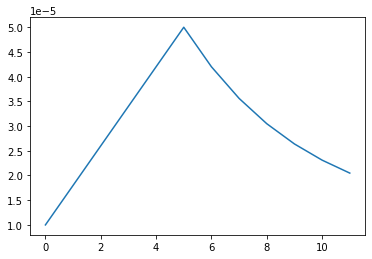

In [20]:
from matplotlib import pyplot as plt

# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [21]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES//BATCH_SIZE
history = model.fit(
    parsed_image_dataset,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
    use_multiprocessing=True
    )

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
99/99 [==============================] - 49s 397ms/step - loss: 4.3115 - sparse_categorical_accuracy: 0.0544 - val_loss: 3.8916 - val_sparse_categorical_accuracy: 0.1207


2022-12-03 06:13:14.739699: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 3172, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670047994.736119666","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 3172, Output num: 1","grpc_status":3}


Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
99/99 [==============================] - 23s 230ms/step - loss: 3.8393 - sparse_categorical_accuracy: 0.1508 - val_loss: 3.6902 - val_sparse_categorical_accuracy: 0.1740
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
99/99 [==============================] - 23s 232ms/step - loss: 3.6538 - sparse_categorical_accuracy: 0.1939 - val_loss: 3.5811 - val_sparse_categorical_accuracy: 0.2012
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
99/99 [==============================] - 23s 231ms/step - loss: 3.5587 - sparse_categorical_accuracy: 0.2117 - val_loss: 3.5331 - val_sparse_categorical_accuracy: 0.2126
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 8.648000176530332e-05.
99/99 [==============================] - 23s 231ms/step - loss: 3.4856 - sparse_categorical_accuracy: 0.2

In [22]:
def plot_hist(history,EPOCHS):
    plt.subplot(2,1,1)
    loss = history.history['loss']
    vloss = history.history['val_loss']
    plt.plot(range(1,EPOCHS+1),loss,c='b',label='loss')
    plt.plot(range(1,EPOCHS+1),vloss,c='r',label='val_loss')
    plt.legend()
    plt.subplot(2,1,2)
    acc = history.history['sparse_categorical_accuracy']
    vacc = history.history['val_sparse_categorical_accuracy']
    plt.plot(range(1,EPOCHS+1),acc,c='b',label='accuracy')
    plt.plot(range(1,EPOCHS+1),vacc,c='r',label='val_accuracy')
    plt.legend()
    plt.plot()

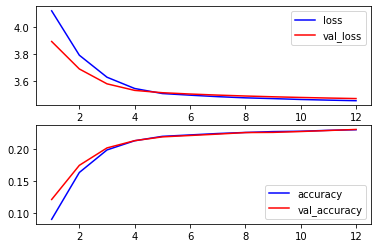

In [23]:
plot_hist(history, EPOCHS)

In [ ]:
iter_data = iter(test_data)
td = next(iter_data)
sub_data = []
while td is not None:
    pred = np.argmax(model.predict(td))
    td = next(iter_data)

49
4
67
67
103
13
49
103
49
53
73
49
4
49
4
67
67
67
103
67
67
73
49
67
67
49
103
49
103
49
67
48
49
67
103
67
73
103
73
67
67
49
49
103
103
4
49
48
67
103
49
53
49
73
67
49
49
67
67
67
73
73
49
73
73
48
102
49
103
4
49
103
49
4
67
67
103
103
73
67
53
53
67
73
103
73
4
73
49
4
103
4
4
80
53
103
103
103
103
4
67
73
67
67
103
76
73
4
103
67
49
73
103
49
73
67
49
13
49
67
13
49
103
4
73
73
67
102
103
4
67
49
49
49
67
67
67
67
49
67
67
103
103
67
48
49
49
49
103
103
103
49
49
73
103
49
73
67
49
67
4
67
67
102
48
67
67
67
73
103
49
80
73
73
49
67
13
4
49
49
67
73
48
103
103
67
103
67
48
73
49
103
67
103
67
67
103
73
67
67
67
67
48
49
102
67
49
49
103
103
80
73
67
73
53
103
48
4
67
67
49
67
103
103
67
67
73
73
73
49
49
103
49
49
103
103
67
103
49
103
103
73
67
49
73
67
67
4
4
49
67
4
73
49
67
49
67
4
67
73
73
67
103
73
67
53
53
49
4
48
67
73
48
102
4
73
49
73
48
49
67
67
67
67
48
48
48
73
67
73
67
67
67
67
48
73
4
73
4
4
67
67
103
67
49
67
67
103
103
103
4
67
4
103
49
48
103
67
73
4
103
75
5